In [0]:
import tensorflow as tf #machine learning
import numpy as np #matrix math
import datetime #logging the time for model checkpoints and training
import matplotlib.pyplot as plt #visualize results
%matplotlib inline

#Step 1 - Collect dataset
#MNIST - handwritten character digits ~50K training and validation images + labels, 10K testing

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
def discriminator(x_image, reuse=False):
    if (reuse):
        tf.get_variable_scope().reuse_variables()

    # First convolutional and pool layers
    # 32 different 5 x 5 pixel features
    # First image through a convolutional layer. 
    # create our weight and bias variables through tf.get_variable. 
    #Our first weight matrix (or filter) will be of size 5x5 and will have a output depth of 32. 
    #It will be randomly initialized from a normal distribution.
    
    # truncated_normal_initializer = for initializing weights
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.01))
    
    # tf.constant_init generates tensors with constant values.
    # for bias initialization
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    # tf.nn.conv2d() is the Tensorflow’s function for a common convolution.
    # It takes in 4 arguments. The first is the input volume (our 28 x 28 x 1 image in this case),next argument is the filter/weight matrix. 
    # you can also change the stride and 
    # padding of the convolution. Those two values affect the dimensions of the output volume.
    # "SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, 
    # it will add the extra column to the right,
    # strides = [batch, height, width, channels]
    d1 = tf.nn.conv2d(input=x_image, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    #add the bias
    d1 = d1 + d_b1
    #squash with nonlinearity (ReLU)
    d1 = tf.nn.relu(d1)
    
    # average pooling layer performs down-sampling by dividing the input into rectangular pooling regions and computing the average of each region. 
    # It returns the averages for the pooling regions.
    # ksize : window size for each tensor for average pooling as the size of input to tensor is in 4-D
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    #As with any convolutional neural network, this module is repeated, 
    # Second convolutional and pool layers
    # These search for 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.01))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    #and then followed by a series of fully connected layers. 
    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.01))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    
    # vector therefore used reshape
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    # linear
    d3 = d3 + d_b3
    # non-linear
    d3 = tf.nn.relu(d3)

    #The last fully-connected layer holds the output, such as the class scores.
    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.01))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))

    #At the end of the network, we do a final matrix multiply and 
    #return the activation value. 
    #For those of you comfortable with CNNs, this is just a simple binary classifier. Nothing fancy.
    # Final layer
    d4 = tf.matmul(d3, d_w4) + d_b4
    # d4 dimensions: batch_size x 1

    return d4

In [0]:
#it takes random inputs, and eventually mapping them down to a [1,28,28] pixel to match the MNIST data shape.  
# 1 here is for single image generation  [1,28,28]
# but 1 in input for discriminator is for channel [28,28,1]
#Be begin by generating a dense 14×14 set of values, and then run through a handful of filters of
#varying sizes and numbers of channels
#weight matrices get progressively smaller

def generator(batch_size, z_dim):
    z = tf.truncated_normal([batch_size, z_dim], mean=0, stddev=1, name='z')
    #first deconv block
    # 7*7*64 = Volume
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.01))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.01))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    # batch normalization
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.01))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.01))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.01))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.01))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.01))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.01))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # No batch normalization at the final layer, but we do add
    # a sigmoid activator to make the generated images crisper.
    # Dimensions of g4: batch_size x 28 x 28 x 1

    return g4

In [0]:
sess = tf.Session()

batch_size = 50
z_dimensions = 100

x_placeholder = tf.placeholder("float", shape = [None,28,28,1], name='x_placeholder')
# x_placeholder is for feeding input images to the discriminator
# need to formulate loss functions that affect both networks. 


Gz = generator(batch_size, z_dimensions)
# Gz holds the generated images
# g(z)

Dx = discriminator(x_placeholder)
# Dx hold the discriminator's prediction probabilities
# for real MNIST images
# d(x)

Dg = discriminator(Gz, reuse=True)
# Dg holds discriminator prediction probabilities for generated images
# d(g(z))

# generator loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))


# discriminator loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.fill([batch_size, 1], 0.9)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

# Train the discriminator
# Increasing from 0.001 in GitHub version
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE) as scope:
  with tf.variable_scope('fake-optimizer'):
    d_trainer_fake = tf.train.AdamOptimizer(0.0001).minimize(d_loss_fake, var_list=d_vars)
  with tf.variable_scope('real-optimizer'):
    d_trainer_real = tf.train.AdamOptimizer(0.0001).minimize(d_loss_real, var_list=d_vars)

    # Train the generator
    # Decreasing from 0.004 in GitHub version
  with tf.variable_scope('optimizer'):
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#Outputs a Summary protocol buffer containing a single scalar value.
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

d_real_count_ph = tf.placeholder(tf.float32)
d_fake_count_ph = tf.placeholder(tf.float32)
g_count_ph = tf.placeholder(tf.float32)

tf.summary.scalar('d_real_count', d_real_count_ph)
tf.summary.scalar('d_fake_count', d_fake_count_ph)
tf.summary.scalar('g_count', g_count_ph)

# Sanity check to see how the discriminator evaluates
# generated and real MNIST images
d_on_generated = tf.reduce_mean(discriminator(generator(batch_size, z_dimensions)))
d_on_real = tf.reduce_mean(discriminator(x_placeholder))

tf.summary.scalar('d_on_generated_eval', d_on_generated)
tf.summary.scalar('d_on_real_eval', d_on_real)

images_for_tensorboard = generator(batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 10)
merged = tf.summary.merge_all()
logdir = "tensorboard/gan/"
writer = tf.summary.FileWriter(logdir, sess.graph)
print(logdir)

tensorboard/gan/


TRAINING STEP 0 AT 2019-04-17 10:12:23.419064
Discriminator classification [-0.00066087]


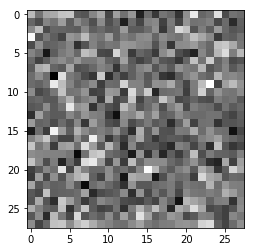

Discriminator classification [-0.00066022]


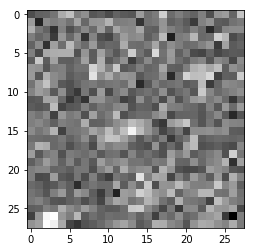

Discriminator classification [-0.00066161]


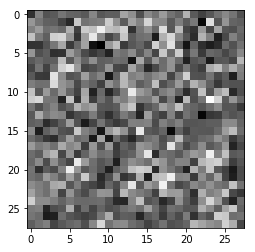

saved to models/pretrained_gan.ckpt-0
TRAINING STEP 1000 AT 2019-04-17 10:12:39.652420
Discriminator classification [0.9876904]


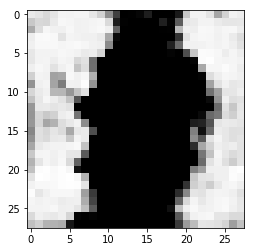

Discriminator classification [0.97822607]


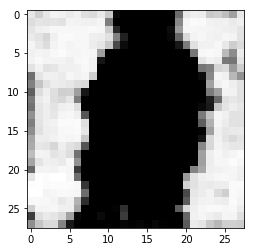

Discriminator classification [0.9553182]


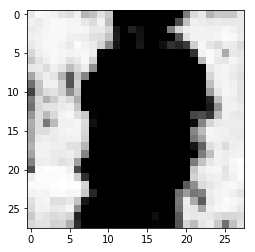

TRAINING STEP 2000 AT 2019-04-17 10:12:53.975674
Discriminator classification [-0.00508367]


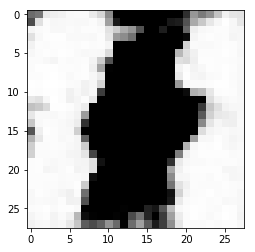

Discriminator classification [-0.02796613]


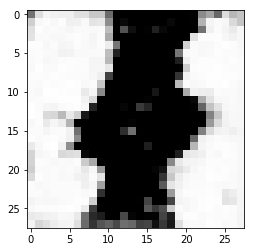

Discriminator classification [0.02420969]


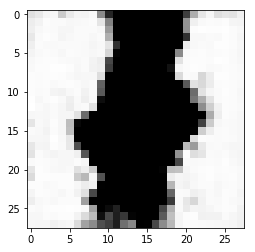

TRAINING STEP 3000 AT 2019-04-17 10:13:08.785784
Discriminator classification [-0.42178926]


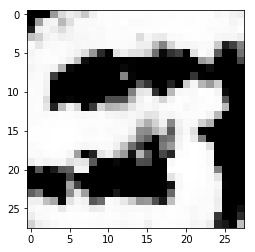

Discriminator classification [-0.2932202]


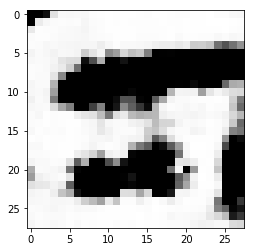

Discriminator classification [-0.23738869]


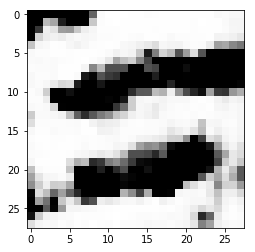

TRAINING STEP 4000 AT 2019-04-17 10:13:23.241266
Discriminator classification [-1.0988935]


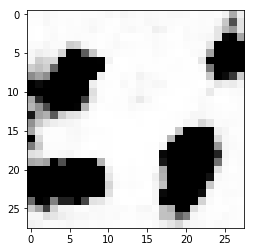

Discriminator classification [-0.54106605]


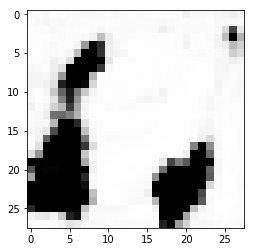

Discriminator classification [-1.039221]


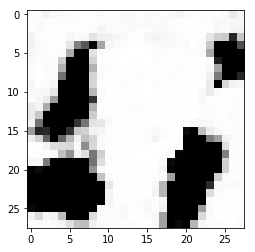

TRAINING STEP 5000 AT 2019-04-17 10:13:37.120151
Discriminator classification [-0.35747734]


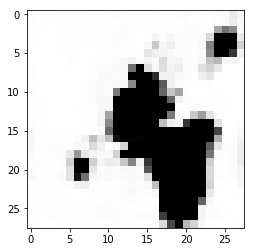

Discriminator classification [-0.19994487]


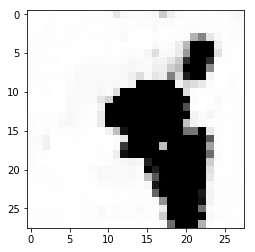

Discriminator classification [-0.45832628]


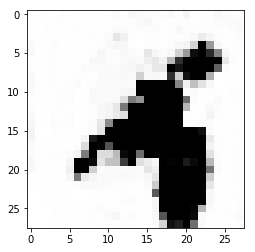

saved to models/pretrained_gan.ckpt-5000
TRAINING STEP 6000 AT 2019-04-17 10:13:51.678310
Discriminator classification [-0.20144804]


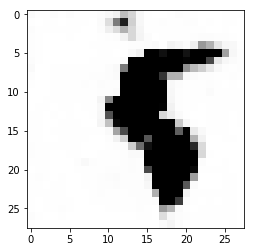

Discriminator classification [-0.37596616]


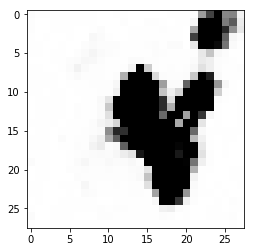

Discriminator classification [-0.6232227]


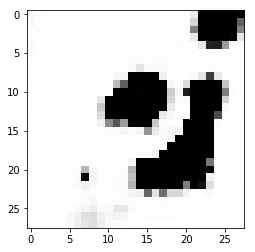

TRAINING STEP 7000 AT 2019-04-17 10:14:06.924931
Discriminator classification [-0.0343647]


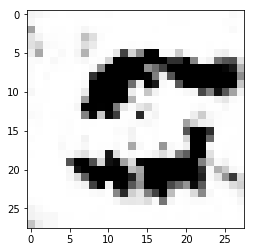

Discriminator classification [0.44095355]


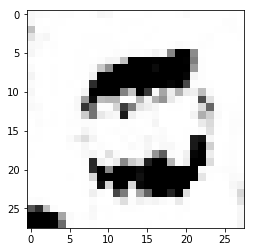

Discriminator classification [1.3900329]


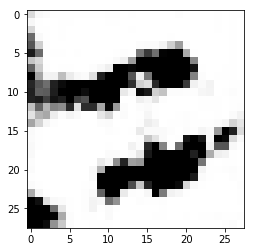

TRAINING STEP 8000 AT 2019-04-17 10:14:21.831104
Discriminator classification [-0.04416204]


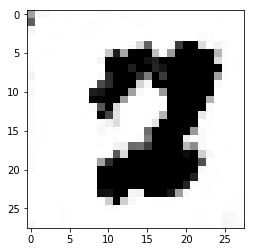

Discriminator classification [0.27717435]


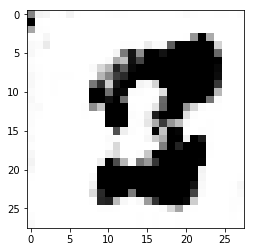

Discriminator classification [-0.31423572]


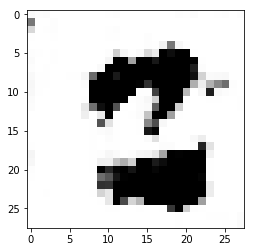

TRAINING STEP 9000 AT 2019-04-17 10:14:36.785902
Discriminator classification [0.5042183]


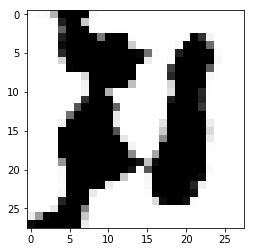

Discriminator classification [-1.2163198]


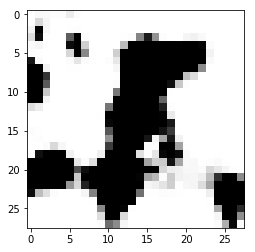

Discriminator classification [-1.0911053]


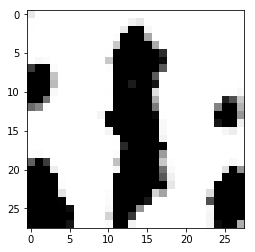

TRAINING STEP 10000 AT 2019-04-17 10:14:51.100035
Discriminator classification [0.87465066]


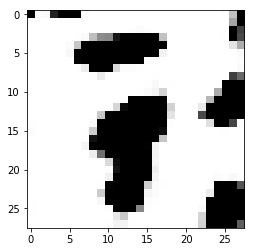

Discriminator classification [-0.45726871]


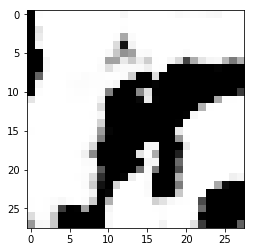

Discriminator classification [0.7633244]


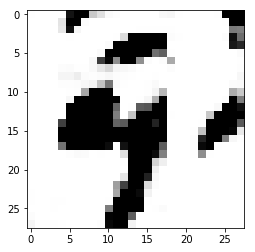

saved to models/pretrained_gan.ckpt-10000
TRAINING STEP 11000 AT 2019-04-17 10:15:06.075398
Discriminator classification [-0.8121771]


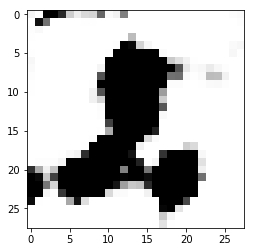

Discriminator classification [0.1519754]


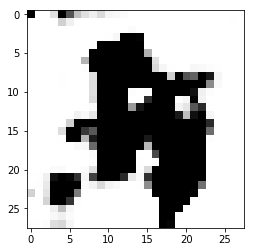

Discriminator classification [-1.0332141]


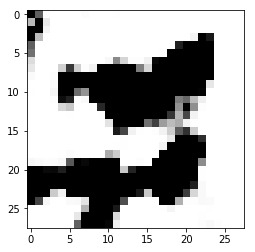

TRAINING STEP 12000 AT 2019-04-17 10:15:20.445122
Discriminator classification [0.12207295]


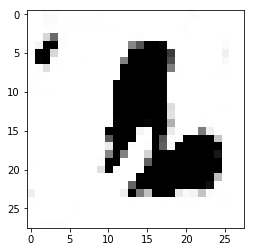

Discriminator classification [-0.3786467]


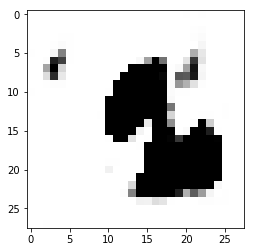

Discriminator classification [-0.74473315]


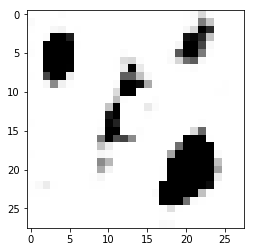

TRAINING STEP 13000 AT 2019-04-17 10:15:34.665445
Discriminator classification [0.6119277]


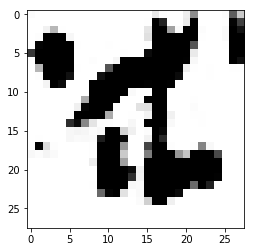

Discriminator classification [2.0295334]


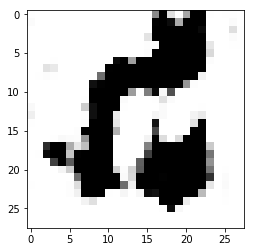

Discriminator classification [1.1393096]


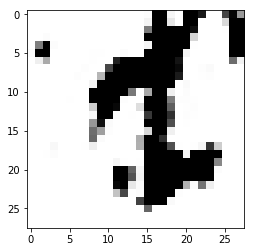

TRAINING STEP 14000 AT 2019-04-17 10:15:49.906985
Discriminator classification [-0.1091764]


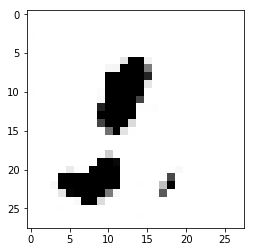

Discriminator classification [-0.23895727]


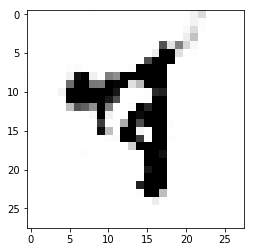

Discriminator classification [-0.5461504]


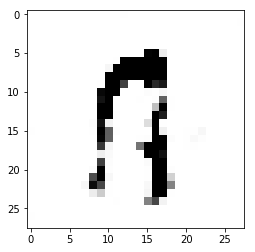

TRAINING STEP 15000 AT 2019-04-17 10:16:05.700781
Discriminator classification [-0.6278162]


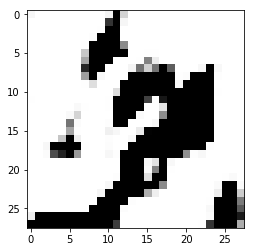

Discriminator classification [-0.1143676]


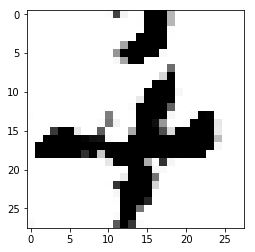

Discriminator classification [-1.0177995]


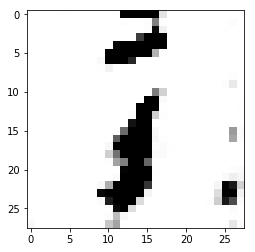

saved to models/pretrained_gan.ckpt-15000
TRAINING STEP 16000 AT 2019-04-17 10:16:21.703893
Discriminator classification [-2.746937]


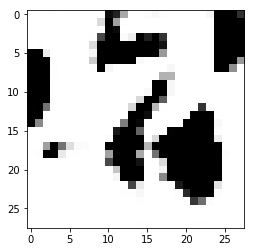

Discriminator classification [-0.5469143]


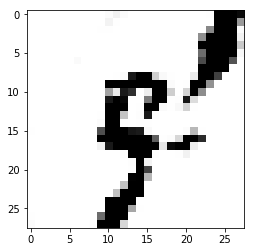

Discriminator classification [0.6512041]


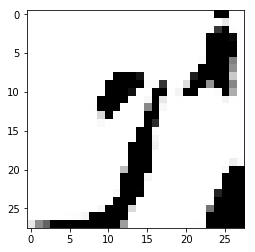

TRAINING STEP 17000 AT 2019-04-17 10:16:36.383409
Discriminator classification [0.5719865]


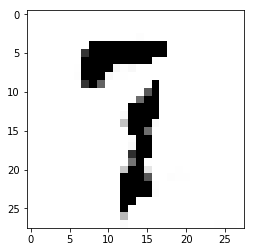

Discriminator classification [-0.58874387]


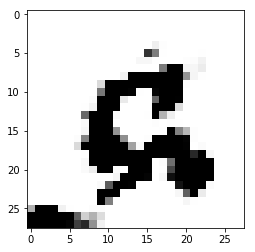

Discriminator classification [-0.03360257]


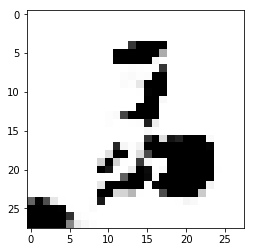

TRAINING STEP 18000 AT 2019-04-17 10:16:52.593047
Discriminator classification [0.8405335]


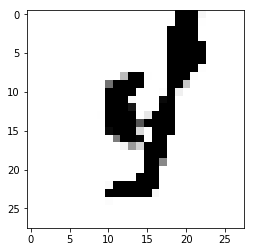

Discriminator classification [-1.4930189]


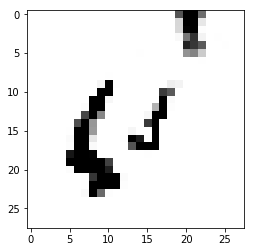

Discriminator classification [-0.04820862]


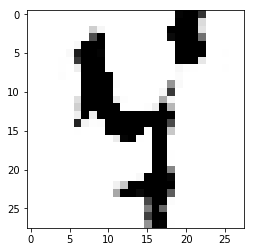

TRAINING STEP 19000 AT 2019-04-17 10:17:09.663458
Discriminator classification [0.17877722]


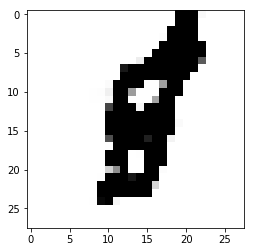

Discriminator classification [-0.7484125]


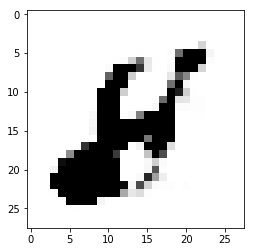

Discriminator classification [-0.52258694]


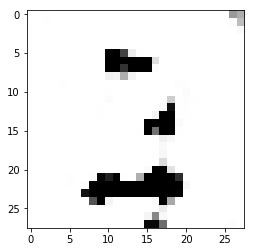

TRAINING STEP 20000 AT 2019-04-17 10:17:26.698545
Discriminator classification [-1.0916808]


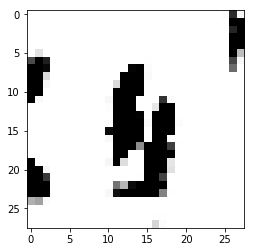

Discriminator classification [0.14455754]


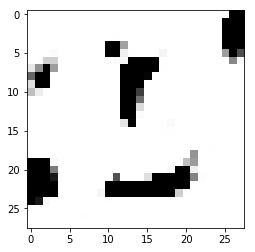

Discriminator classification [0.71829593]


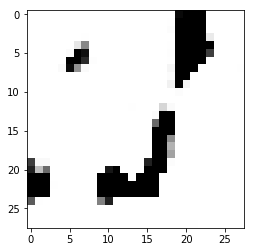

saved to models/pretrained_gan.ckpt-20000
TRAINING STEP 21000 AT 2019-04-17 10:17:44.411237
Discriminator classification [-1.9552757]


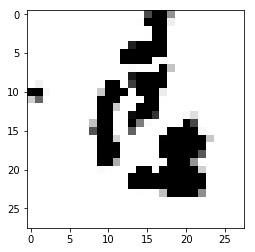

Discriminator classification [-1.2475095]


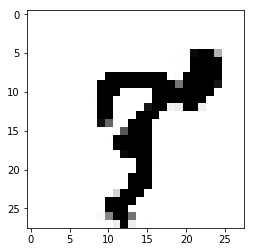

Discriminator classification [-1.6136726]


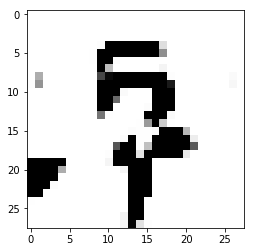

TRAINING STEP 22000 AT 2019-04-17 10:18:01.301380
Discriminator classification [-0.5365078]


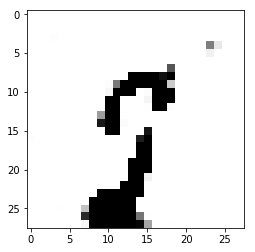

Discriminator classification [-0.76005435]


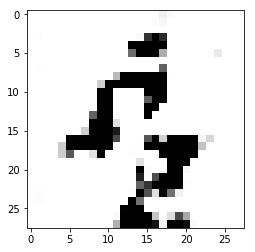

Discriminator classification [-0.18784359]


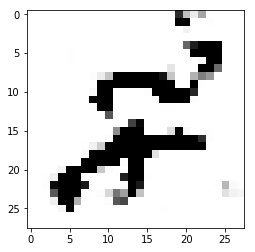

TRAINING STEP 23000 AT 2019-04-17 10:18:18.272102
Discriminator classification [0.42158467]


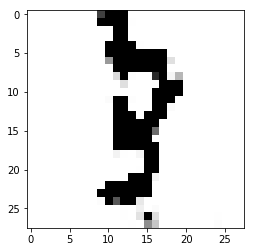

Discriminator classification [0.62598914]


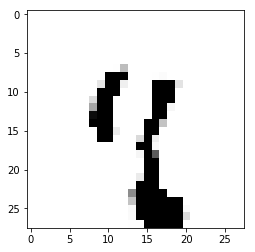

Discriminator classification [0.09156255]


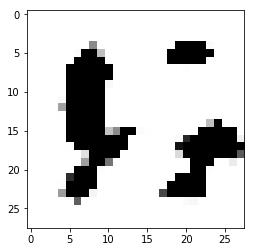

TRAINING STEP 24000 AT 2019-04-17 10:18:35.267430
Discriminator classification [0.48226333]


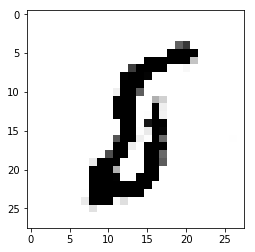

Discriminator classification [0.38631824]


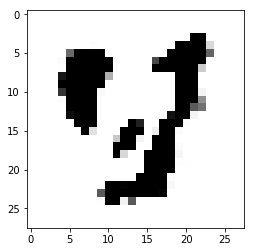

Discriminator classification [0.72987103]


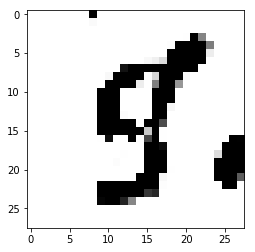

TRAINING STEP 25000 AT 2019-04-17 10:18:52.130379
Discriminator classification [1.1650504]


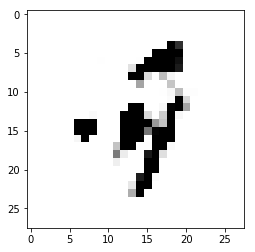

Discriminator classification [0.4961674]


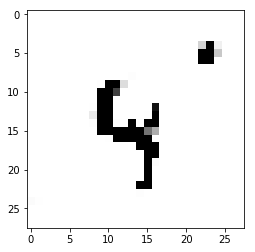

Discriminator classification [2.6482089]


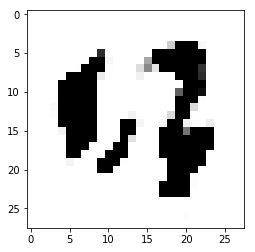

Instructions for updating:
Use standard file APIs to delete files with this prefix.
saved to models/pretrained_gan.ckpt-25000
TRAINING STEP 26000 AT 2019-04-17 10:19:09.198459
Discriminator classification [-0.2537895]


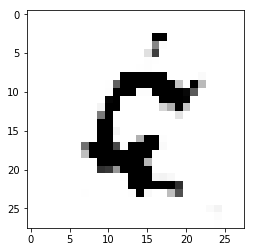

Discriminator classification [-0.07859915]


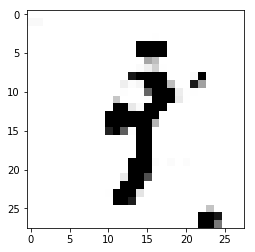

Discriminator classification [-0.21861497]


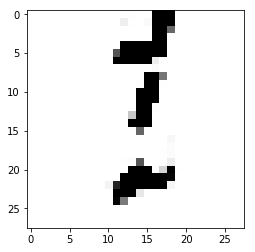

TRAINING STEP 27000 AT 2019-04-17 10:19:26.283632
Discriminator classification [1.180752]


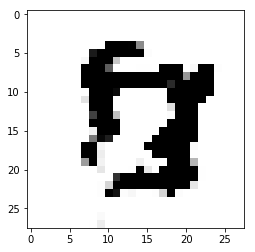

Discriminator classification [0.17770115]


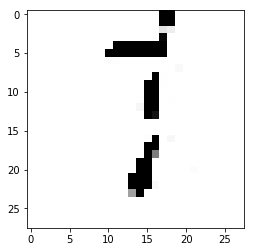

Discriminator classification [-0.09595173]


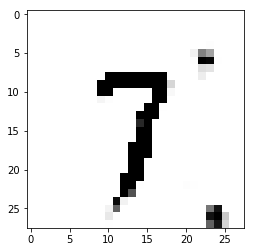

TRAINING STEP 28000 AT 2019-04-17 10:19:43.654220
Discriminator classification [0.1094154]


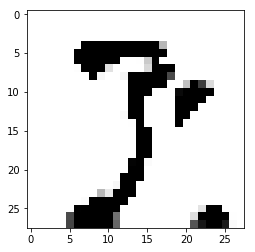

Discriminator classification [0.1759001]


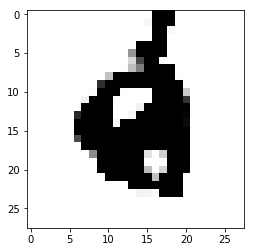

Discriminator classification [0.32635128]


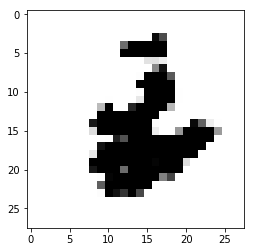

TRAINING STEP 29000 AT 2019-04-17 10:20:00.813105
Discriminator classification [0.15310356]


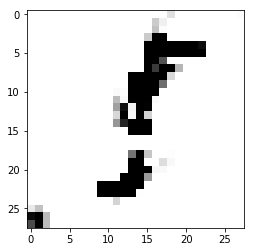

Discriminator classification [0.06274233]


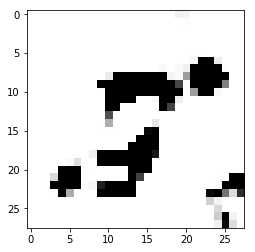

Discriminator classification [0.35662866]


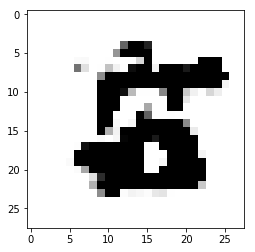

TRAINING STEP 30000 AT 2019-04-17 10:20:18.331110
Discriminator classification [-0.3667202]


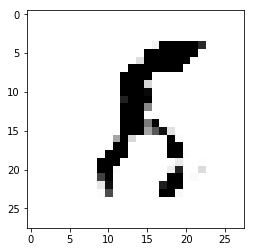

Discriminator classification [0.5232669]


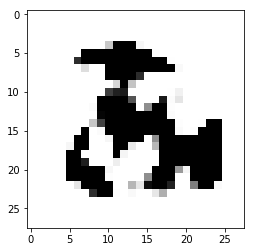

Discriminator classification [0.1594816]


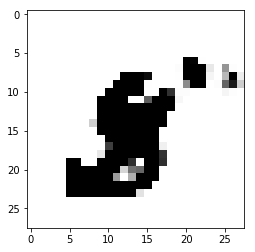

saved to models/pretrained_gan.ckpt-30000
TRAINING STEP 31000 AT 2019-04-17 10:20:34.761967
Discriminator classification [-0.37822172]


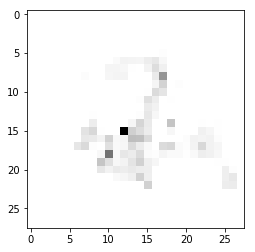

Discriminator classification [-0.3594933]


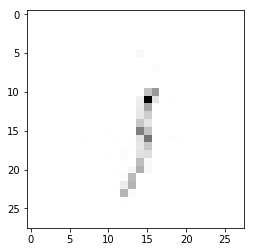

Discriminator classification [-0.19452521]


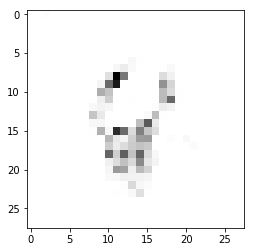

TRAINING STEP 32000 AT 2019-04-17 10:20:47.530238
Discriminator classification [-0.30480826]


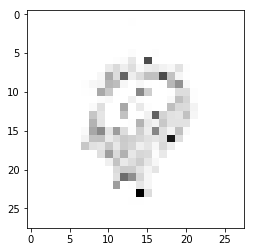

Discriminator classification [-0.22044176]


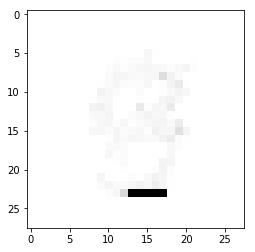

Discriminator classification [-0.22265968]


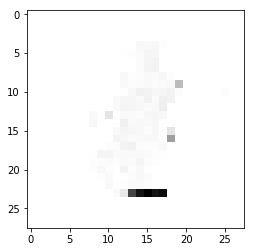

TRAINING STEP 33000 AT 2019-04-17 10:21:00.644212
Discriminator classification [-0.2698757]


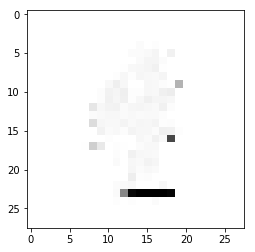

Discriminator classification [-0.18919381]


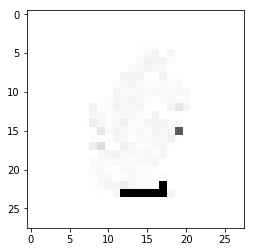

Discriminator classification [-0.20165567]


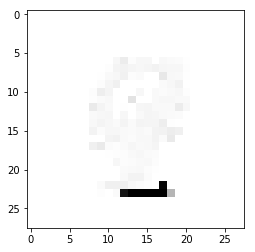

TRAINING STEP 34000 AT 2019-04-17 10:21:13.525596
Discriminator classification [-0.26374677]


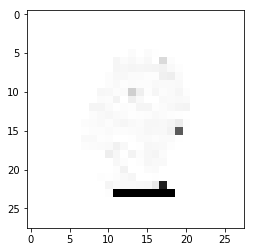

Discriminator classification [-0.22665085]


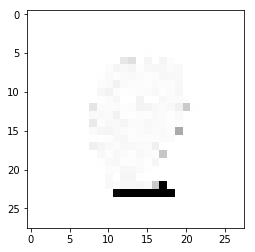

Discriminator classification [-0.2715653]


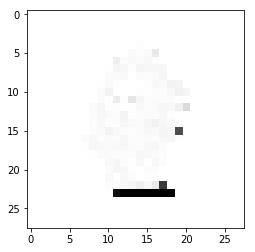

TRAINING STEP 35000 AT 2019-04-17 10:21:26.577524
Discriminator classification [-0.38326907]


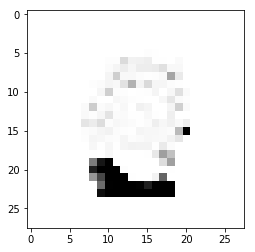

Discriminator classification [-0.3268042]


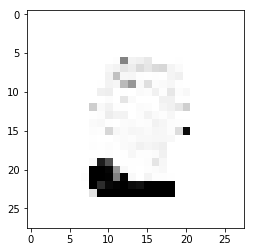

Discriminator classification [-0.30838344]


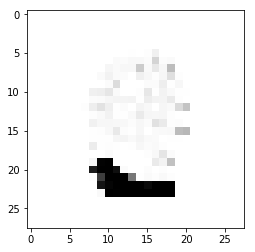

saved to models/pretrained_gan.ckpt-35000
TRAINING STEP 36000 AT 2019-04-17 10:21:40.093222
Discriminator classification [-0.18797386]


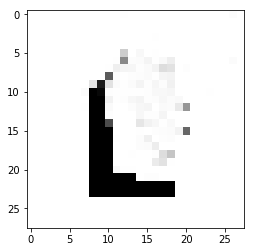

Discriminator classification [-0.42116144]


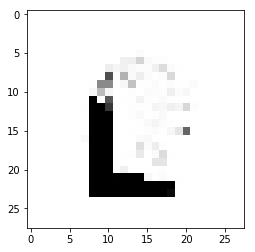

Discriminator classification [-0.46849513]


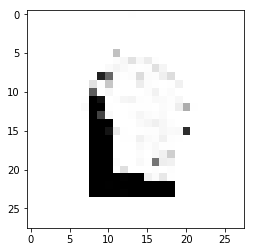

TRAINING STEP 37000 AT 2019-04-17 10:21:56.986774
Discriminator classification [-0.73370385]


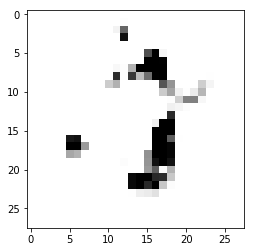

Discriminator classification [-0.12485299]


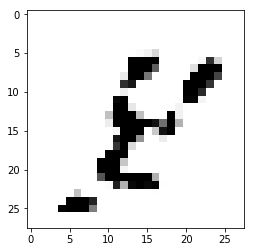

Discriminator classification [-0.14992546]


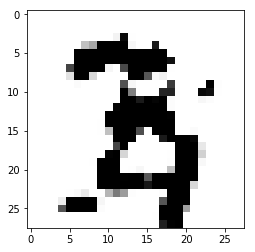

TRAINING STEP 38000 AT 2019-04-17 10:22:14.016311
Discriminator classification [0.6388177]


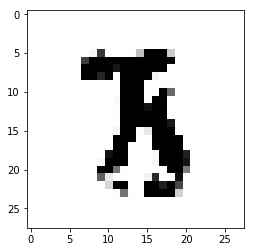

Discriminator classification [0.56208575]


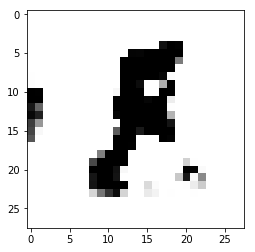

Discriminator classification [0.41614014]


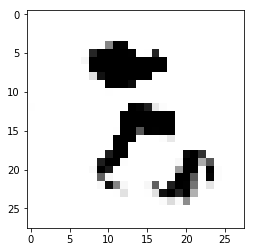

TRAINING STEP 39000 AT 2019-04-17 10:22:30.381629
Discriminator classification [0.6922493]


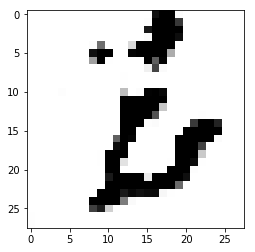

Discriminator classification [-0.70710593]


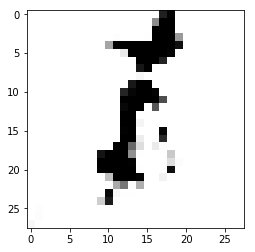

Discriminator classification [0.3538858]


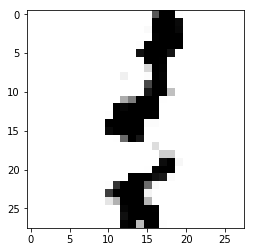

TRAINING STEP 40000 AT 2019-04-17 10:22:47.282975
Discriminator classification [0.21163327]


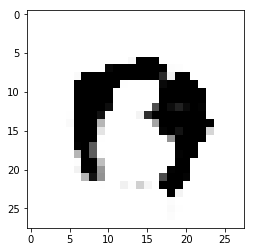

Discriminator classification [0.8021828]


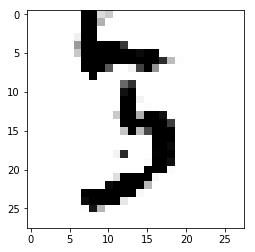

Discriminator classification [0.3305383]


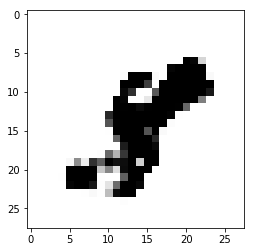

saved to models/pretrained_gan.ckpt-40000
TRAINING STEP 41000 AT 2019-04-17 10:23:04.731296
Discriminator classification [-0.36711785]


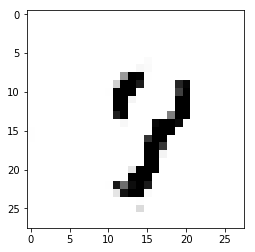

Discriminator classification [-0.54215246]


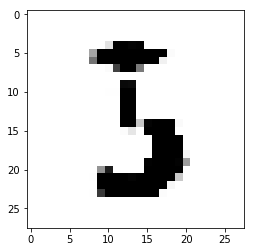

Discriminator classification [0.76747453]


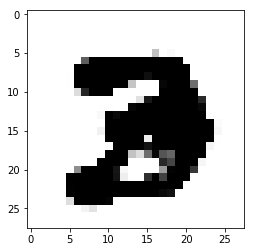

TRAINING STEP 42000 AT 2019-04-17 10:23:21.653566
Discriminator classification [-0.20127264]


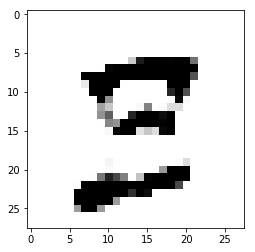

Discriminator classification [-0.70165414]


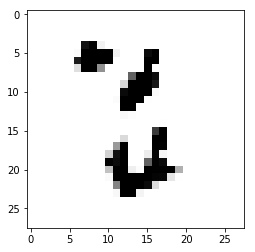

Discriminator classification [0.50711626]


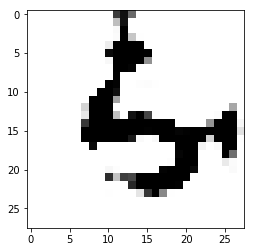

TRAINING STEP 43000 AT 2019-04-17 10:23:38.676517
Discriminator classification [-0.5201679]


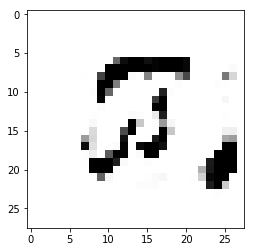

Discriminator classification [-0.00654837]


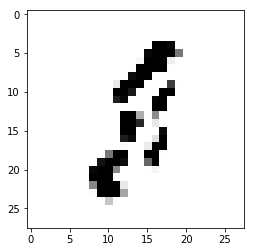

Discriminator classification [0.8741051]


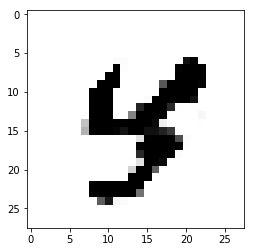

TRAINING STEP 44000 AT 2019-04-17 10:23:55.355553
Discriminator classification [0.9336749]


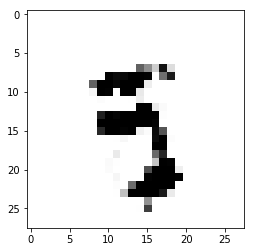

Discriminator classification [1.3653063]


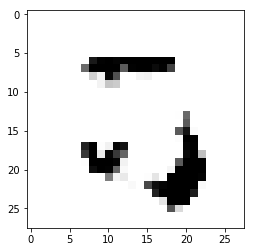

Discriminator classification [2.1966288]


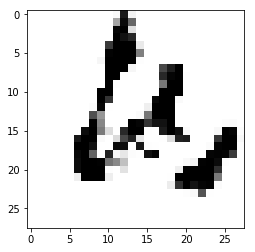

TRAINING STEP 45000 AT 2019-04-17 10:24:11.833048
Discriminator classification [0.08103662]


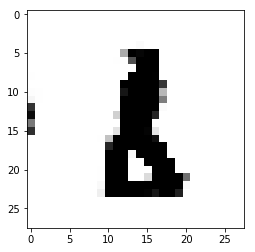

Discriminator classification [-0.7895106]


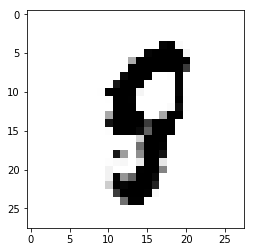

Discriminator classification [0.06180041]


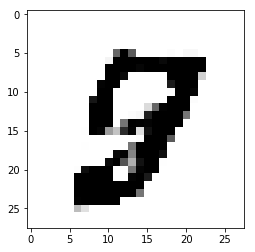

saved to models/pretrained_gan.ckpt-45000
TRAINING STEP 46000 AT 2019-04-17 10:24:28.728541
Discriminator classification [-0.32049936]


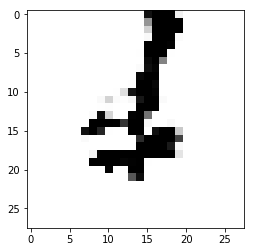

Discriminator classification [-1.6389976]


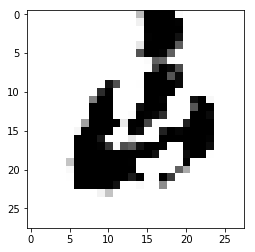

Discriminator classification [-0.9340045]


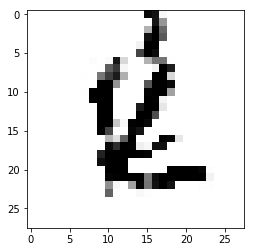

TRAINING STEP 47000 AT 2019-04-17 10:24:45.102239
Discriminator classification [2.537658]


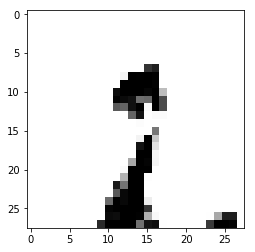

Discriminator classification [4.873918]


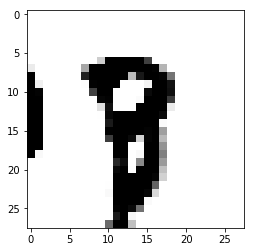

Discriminator classification [4.9643207]


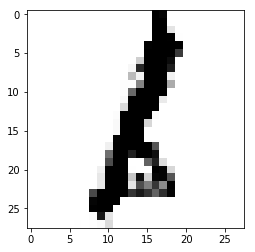

TRAINING STEP 48000 AT 2019-04-17 10:25:00.989530
Discriminator classification [-2.6738665]


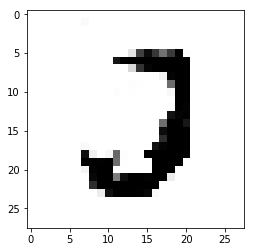

Discriminator classification [-2.9300163]


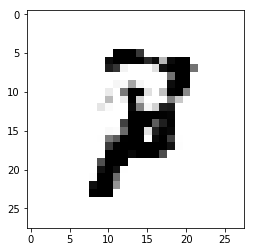

Discriminator classification [-3.106417]


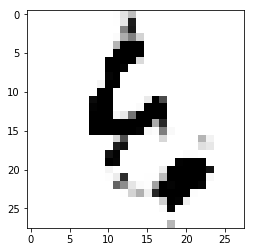

TRAINING STEP 49000 AT 2019-04-17 10:25:16.659420
Discriminator classification [0.20628431]


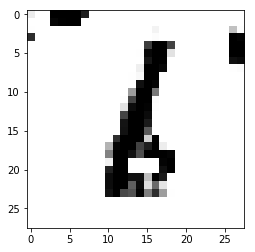

Discriminator classification [1.8115941]


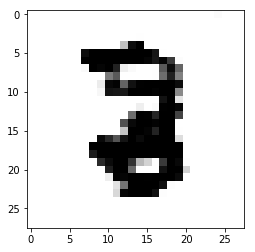

Discriminator classification [-0.08997842]


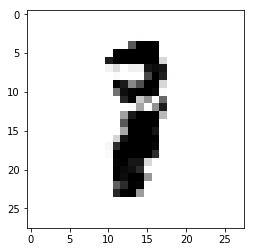

In [0]:
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

#During every iteration, there will be two updates being made, one to the discriminator and one to the generator. 
#For the generator update, we’ll feed in a random z vector to the generator and pass that output to the discriminator
#to obtain a probability score (this is the Dg variable we specified earlier).
#As we remember from our loss function, the cross entropy loss gets minimized, 
#and only the generator’s weights and biases get updated.
#We'll do the same for the discriminator update. We’ll be taking a batch of images 
#from the mnist variable we created way at the beginning of our program.
#These will serve as the positive examples, while the images in the previous section are the negative ones.

gLoss = 0
dLossFake, dLossReal = 1, 1
d_real_count, d_fake_count, g_count = 0, 0, 0
for i in range(50000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    if dLossFake > 0.6:
        # Train discriminator on generated images
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_fake, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_fake_count += 1

    if gLoss > 0.5:
        # Train the generator
        _, dLossReal, dLossFake, gLoss = sess.run([g_trainer, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        g_count += 1

    if dLossReal > 0.45:
        # If the discriminator classifies real images as fake,
        # train discriminator on real values
        _, dLossReal, dLossFake, gLoss = sess.run([d_trainer_real, d_loss_real, d_loss_fake, g_loss],
                                                    {x_placeholder: real_image_batch})
        d_real_count += 1

    if i % 10 == 0:
        real_image_batch = mnist.validation.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        summary = sess.run(merged, {x_placeholder: real_image_batch, d_real_count_ph: d_real_count,
                                    d_fake_count_ph: d_fake_count, g_count_ph: g_count})
        writer.add_summary(summary, i)
        d_real_count, d_fake_count, g_count = 0, 0, 0

    if i % 1000 == 0:
        # Periodically display a sample image in the notebook
        # (These are also being sent to TensorBoard every 10 iterations)
        images = sess.run(generator(3, z_dimensions))
        d_result = sess.run(discriminator(x_placeholder), {x_placeholder: images})
        print("TRAINING STEP", i, "AT", datetime.datetime.now())
        for j in range(3):
            print("Discriminator classification", d_result[j])
            im = images[j, :, :, 0]
            plt.imshow(im.reshape([28, 28]), cmap='Greys')
            plt.show()

    if i % 5000 == 0:
        save_path = saver.save(sess, "models/pretrained_gan.ckpt", global_step=i)
        print("saved to %s" % save_path)


[5.5770483]


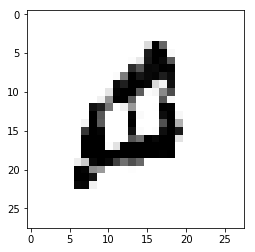

[4.6846347]


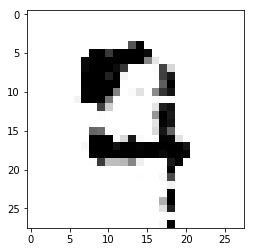

[2.6064742]


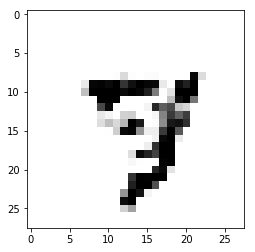

[3.6436517]


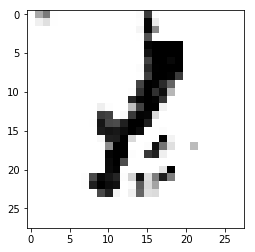

[4.227339]


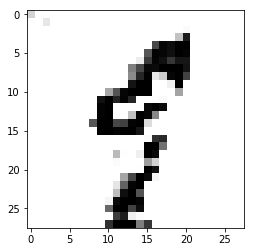

[4.910442]


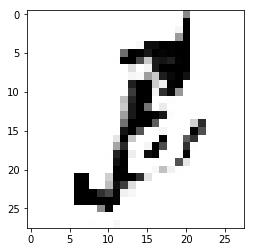

[3.422634]


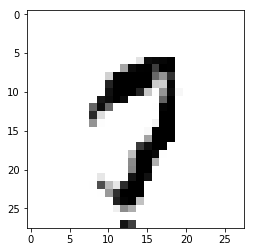

[2.34121]


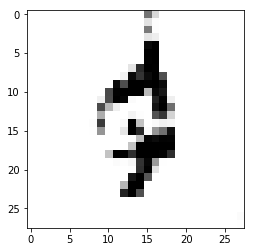

[2.7493174]


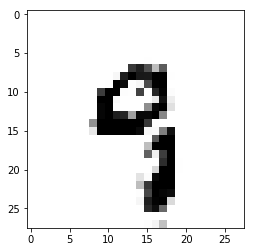

[3.5880022]


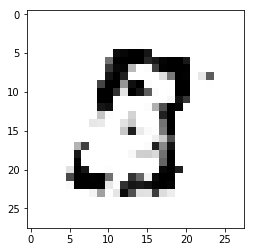

[2.265948]


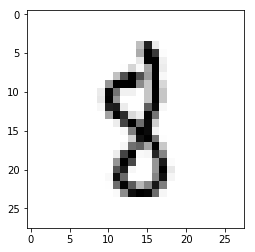

[7.1989255]


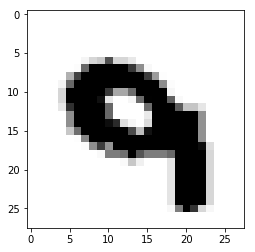

[3.6294744]


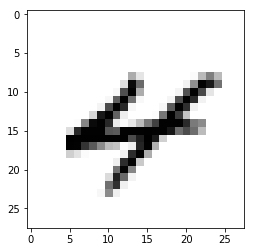

[6.7524023]


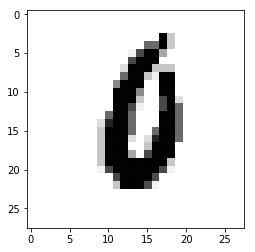

[3.7886298]


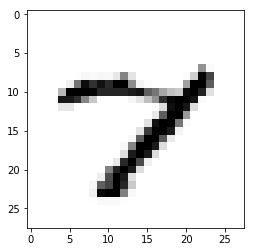

[5.6400084]


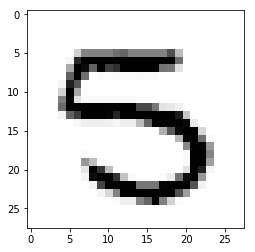

[1.7303873]


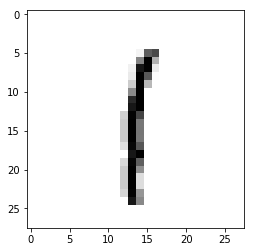

[1.6560466]


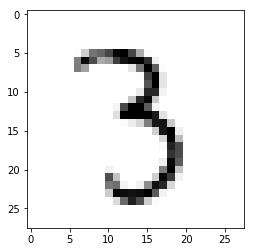

[7.545138]


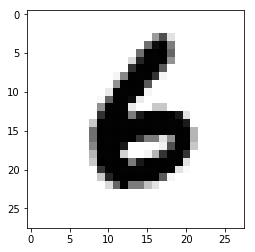

[6.2546315]


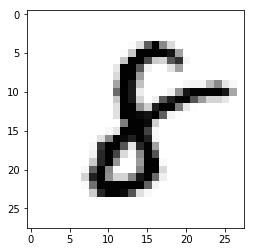

In [0]:
test_images = sess.run(generator(10, 100))
test_eval = sess.run(discriminator(x_placeholder), {x_placeholder: test_images})

real_images = mnist.validation.next_batch(10)[0].reshape([10, 28, 28, 1])
real_eval = sess.run(discriminator(x_placeholder), {x_placeholder: real_images})

# Show discriminator's probabilities for the generated images,
# and display the images
for i in range(10):
    print(test_eval[i])
    plt.imshow(test_images[i, :, :, 0], cmap='Greys')
    plt.show()

# Now do the same for real MNIST images
for i in range(10):
    print(real_eval[i])
    plt.imshow(real_images[i, :, :, 0], cmap='Greys')
    plt.show()

[4.2613373]


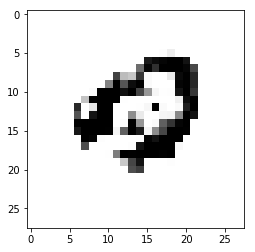

[3.8312328]


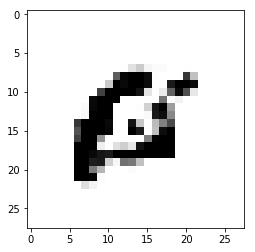

[2.2074049]


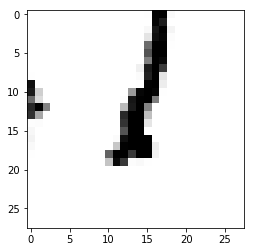

[2.4367542]


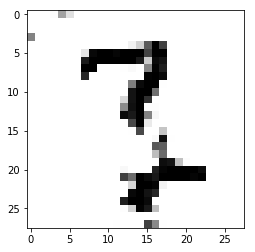

[4.9646373]


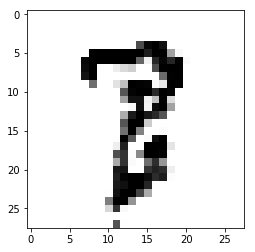

[4.6141315]


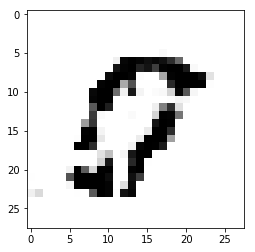

[2.6570773]


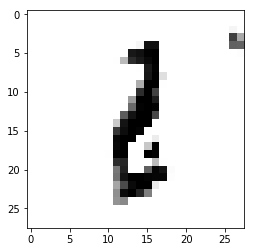

[4.63962]


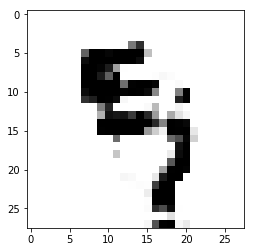

[2.588968]


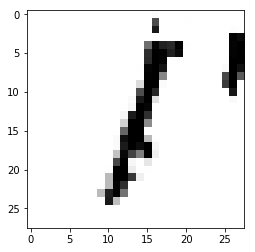

[4.491614]


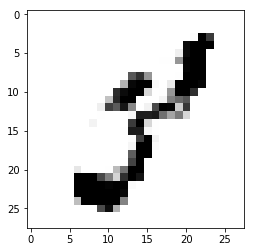

[3.7293134]


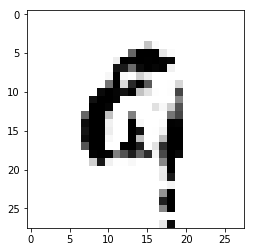

[1.5444705]


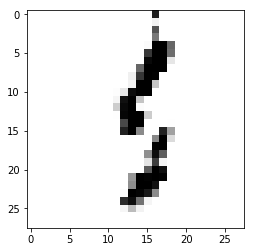

[4.2698073]


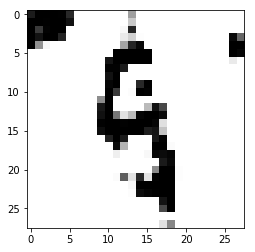

[2.8650072]


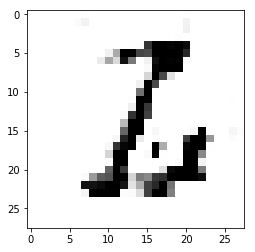

[1.7284915]


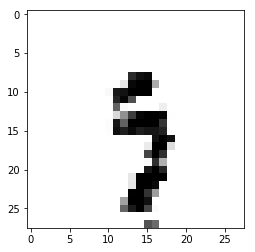

[1.8369671]


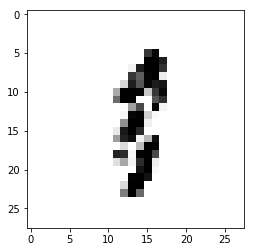

In [0]:
#z = np.random.normal(16)
#generator(10, 100)
test_images = sess.run(generator(16,100))
test_eval = sess.run(discriminator(x_placeholder), {x_placeholder: test_images})
for i in range(16):
    print(test_eval[i])
    plt.imshow(test_images[i, :, :, 0], cmap='Greys')
    plt.show()
